# Project Introduction

## What is the machine learning problem we are trying to solve?
The problem to be solved is predicting the number of streams a song will gather on streaming platforms such as Spotify and Apple Music (in this case specifically spotify). This problem is essential because streaming numbers directly impact revenue generation and popularity metrics in the music industry.

## Why does this problem matter?
Predicting song popularity before they become hits is crucial for several reasons:

- **Strategic Planning**: Artists and record labels can better plan releases and marketing strategies.
- **Financial Forecasting**: Accurate predictions can help forecast revenues generated from streaming, aiding budgeting and financial planning.
- **Resource Allocation**: Knowing which songs are likely to succeed can help in allocating promotional resources effectively.

## What could the results of your predictive model be used for?
1. **Marketing Strategies**: Predictions can guide marketing efforts, helping to decide on release dates and budget allocations based on potential song popularity.
2. **Playlist Curation**: Streaming services can use the model to enhance playlist curation, placing likely popular songs in prominent positions to increase listener engagement.
3. **Resource Allocation**: Insights from the model help prioritize investments in projects and artists expected to yield high returns.
4. **Trend Forecasting**: The model aids in identifying emerging music trends, guiding production and artist development strategies.

## Why would people want to be able to predict the thing we’re trying to predict?
- **Revenue Optimization**: Predicting streams helps maximize revenue from streaming platforms by strategically releasing and promoting tracks.
- **Marketing Efficiency**: By forecasting song popularity, marketers can tailor campaigns more effectively, ensuring better use of promotional budgets.
- **Strategic Planning**: Accurate predictions enable labels and artists to plan releases and tours based on expected song popularity.
- **Industry Trends**: Understanding potential hit songs ahead of time allows the industry to stay ahead of changing musical trends and listener preferences.

## What dataset are we using to make this prediction?
The dataset includes 943 unique songs from the year 2023, compiled from streaming data on platforms like Spotify and Apple Music. Each entry represents a song with attributes that potentially influence its streaming numbers.

Features of the Dataset
The dataset contains 24 features. Key features include:

- **Track Name**: Name of the song.
- **Artist Name**: Artist performing the song.
- **In Spotify Playlist**: Indicates if the song is included in a Spotify playlist.
- **In Apple Playlist**: Indicates if the song is included in an Apple Music playlist.
- **Streams**: Number of times the song has been streamed, which serves as the target variable for prediction.

The dataset enables us to focus on predicting the 'Streams' count for each song using the rest of the data provided. The presence of a clear target variable ('Streams') allows for the application of various regression techniques to model and predict outcomes based on the features provided.



In [ ]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import IsolationForest
import xgboost as xgb

import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
data.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


# Data Cleaning

We used a combination of deletion and imputation (replacing values with 0s) to clean the data. The advantage of this is its simplicity, but we are sacrificing some authenticity in the data.

In [ ]:
# Remove duplicate records
data.drop_duplicates(inplace=True)

# Handle missing values
data.fillna(0, inplace=True)



# Feature Engineering

To better quantify some of the features, we did some feature engineering. Notably, we hypothesized that the release date may correlate with the number of streams, since older songs are more like to be streamed.

We took the existing date features and calculated the number of days since the song was released. We also further cleaned the data to turn numeric values into numeric datatypes in Python.

In [ ]:
# Convert release_year, release_month, release_day to a single date column
data['release_date'] = pd.to_datetime({
    'year': data['released_year'],
    'month': data['released_month'],
    'day': data['released_day']
})
# Calculate the number of days since the song was released
data['days_since_release'] = (pd.Timestamp.now() - data['release_date']).dt.days
data['in_deezer_playlists'] = data['in_deezer_playlists'].str.replace(',', '').astype(float).fillna(0).astype(int)
data['in_shazam_charts'] = data['in_shazam_charts'].str.replace(',', '').astype(float).fillna(0).astype(int)

# Convert 'streams' to numeric and drop rows with non-numeric values
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')
data.dropna(subset=['streams'], inplace=True)


# show what the dataset looks like after engineering
# if you run this block twice it FAILS because we drop the columns we don't use, because of this we could comment out the dropping code
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,release_date,days_since_release
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,Major,80,89,83,31,0,8,4,2023-07-14,284
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,Major,71,61,74,7,0,10,4,2023-03-23,397
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,Major,51,32,53,17,0,31,6,2023-06-30,298
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,Major,55,58,72,11,0,11,15,2019-08-23,1705
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,Minor,65,23,80,14,63,11,6,2023-05-18,341


# Anomaly Detection

We used Isolation Forest since it is relatively low effort from a programming standpoint: we don't have to specify hyperparameters, and we don't have to do any data scaling (while some other methods, especially proximity-based approaches, are less intuitive and require some form of scaling).

In [ ]:
numeric_features = [
    'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists',
    'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
    'in_deezer_charts', 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%',
    'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
    'days_since_release'
]

# using isolation forest because of its lack of need for hyperparams
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict anomalies
anomalies = iso_forest.fit_predict(data[numeric_features])

# Add the anomaly labels to the dataset
data['anomaly'] = anomalies

# Print the number of anomalies detected
print(f"Number of anomalies detected: {len(data[data['anomaly'] == -1])}")
data = data[data['anomaly'] == 1]

data.head()



Number of anomalies detected: 48


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,release_date,days_since_release,anomaly
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,71,61,74,7,0,10,4,2023-03-23,397,1
6,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2,2023,3,16,3090,50,725980112.0,34,...,67,83,76,48,0,8,3,2023-03-16,404,1
7,Columbia,Quevedo,1,2023,7,7,714,43,58149378.0,25,...,67,26,71,37,0,11,4,2023-07-07,291,1
8,fukumean,Gunna,1,2023,5,15,1096,83,95217315.0,60,...,85,22,62,12,0,28,9,2023-05-15,344,1
9,La Bebe - Remix,"Peso Pluma, Yng Lvcas",2,2023,3,17,2953,44,553634067.0,49,...,81,56,48,21,0,8,33,2023-03-17,403,1


# Data Exploration

In this section, we're developing different types of plots on some of the features that we're interested in, so that we can find which features we want to select to train our model.

<Axes: title={'center': 'Distribution of Streams'}, ylabel='Frequency'>

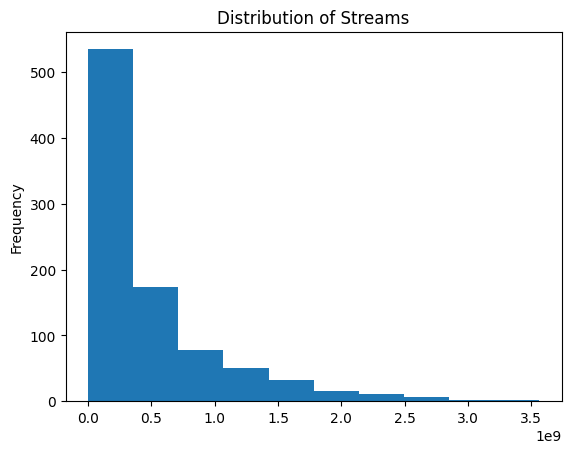

In [ ]:
spotify_streams = data["streams"]
spotify_streams.plot(kind='hist', title = 'Distribution of Streams')

<Axes: title={'center': 'Distribution of Days Since Release'}, ylabel='Frequency'>

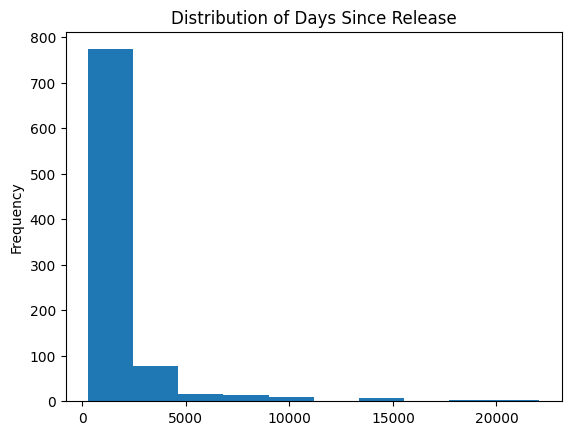

In [ ]:
days_since_release = data["days_since_release"]
days_since_release.plot(kind='hist', title = 'Distribution of Days Since Release')

# From this, we can see that the distribution of streams compared to the distribution
# of days since release are very similar. This led us to construct a bivariate model
# to confirm this result.

In [ ]:
data.plot(x = 'days_since_release', y = 'streams', kind = 'scatter')
plt.show()

# As we can see from this plot, the majority of the data points
# are shown to be concentrated near the origin. This is expected.
# Even then, we can see that for the majority of data points, there
# is a strong positive relationship between the two values

<Axes: title={'center': 'streams'}, xlabel='[mode]'>

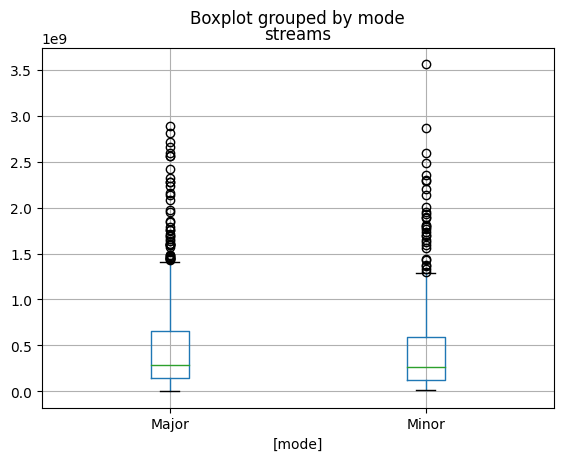

In [ ]:
data.boxplot(column = ["streams"], by = ["mode"])

# We were also interested in seeing if songs in a major key would
# have any major differences with songs in a minor key. This boxplot
# compares to two modes: the overall plots look the same, with
# comparable 1st and 3rd quartiles, and median. This means that being
# in a major or minor key most likely has no significant effect
# on the number of streams.

In [ ]:
numeric_features = [
    'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists',
    'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
    'in_deezer_charts', 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%',
    'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
    'days_since_release'
]

# Split the data into features (X) and target variable (y)
X = data[numeric_features]
y = data['streams']

X.corr().style.background_gradient(cmap='coolwarm')

# We developed a corelation matrix between the numeric features to see if there
# are any features that might be stronger when it comes to predictability.
# Some of the larger correlation values made sense, such as a 0.7 value between
# in_spotify_playlists and in_apple_playlists. Others, however, were less
# intuitive, such as 0.4 (moderate correlation) between days_since_release
# and in_spotify_playlists.

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,days_since_release
artist_count,1.000000,0.136739,0.036057,-0.008575,-0.085851,-0.015979,-0.036783,-0.084348,-0.047721,0.004685,-0.029255,-0.036721,0.207913,0.130225,0.141447,-0.100444,-0.037428,0.026893,0.119627,-0.138026
released_year,0.136739,1.000000,0.007905,0.095283,-0.437062,0.018191,-0.201863,-0.003372,-0.375357,0.097039,0.007091,0.025531,0.130646,-0.009893,-0.014556,0.021944,0.002304,0.004155,0.130635,-0.999080
released_month,0.036057,0.007905,1.000000,0.042989,-0.131444,-0.065495,-0.010560,-0.017224,-0.125107,-0.013431,-0.104743,-0.040937,-0.036238,-0.105516,-0.091795,0.075681,0.045869,-0.016933,0.041417,-0.050627
released_day,-0.008575,0.095283,0.042989,1.000000,-0.093757,-0.018270,0.020342,0.003046,-0.104945,0.042836,0.015872,-0.033642,0.054984,0.072729,0.038554,0.024878,0.016561,0.006590,-0.012575,-0.100529
in_spotify_playlists,-0.085851,-0.437062,-0.131444,-0.093757,1.000000,0.159667,0.706621,0.256003,0.805557,0.121639,0.021003,-0.031562,-0.055408,-0.015900,0.004062,-0.064047,-0.037503,-0.048476,-0.118169,0.442267
in_spotify_charts,-0.015979,0.018191,-0.065495,-0.018270,0.159667,1.000000,0.165239,0.479385,0.096063,0.499645,0.454550,-0.000709,0.054018,0.040861,0.086765,-0.071184,-0.031708,-0.047050,-0.103578,-0.015289
in_apple_playlists,-0.036783,-0.201863,-0.010560,0.020342,0.706621,0.165239,1.000000,0.372888,0.456299,0.312266,0.060401,-0.003899,0.016707,0.063710,0.043933,-0.070827,-0.070244,-0.053945,-0.125511,0.201894
in_apple_charts,-0.084348,-0.003372,-0.017224,0.003046,0.256003,0.479385,0.372888,1.000000,0.148293,0.291728,0.319062,0.013286,-0.005481,0.044639,0.124794,-0.099863,-0.054012,-0.018260,-0.168377,0.004095
in_deezer_playlists,-0.047721,-0.375357,-0.125107,-0.104945,0.805557,0.096063,0.456299,0.148293,1.000000,0.043845,0.012116,-0.026417,-0.039741,0.005629,0.036252,-0.036909,-0.040894,-0.013786,-0.099758,0.380438
in_deezer_charts,0.004685,0.097039,-0.013431,0.042836,0.121639,0.499645,0.312266,0.291728,0.043845,1.000000,0.239959,0.013897,0.103468,0.088047,0.090870,-0.018260,-0.022315,0.005576,-0.076519,-0.096459


# Model Creation

Our main machine learning problem was a regression problem to predict the number of streams - as a result, we explored multiple models and evaluated them for accuracy based on MSE, RMSE, MAE, and R^2 metrics.

We first created a simple linear regression model due to its simplicity in nature. Ackowledging that the model may be too simple for our problem, we also explored a neural network model (which expands on simple linear regression - linear regression is a neural network model with no hidden layers), and an XGBoost regression tree, which utilizes ensembling (specifically, boosting) to hopefully improve the performance.

In [ ]:
# Select the relevant numeric features for the model

# Split the data into features (X) and target variable (y)
X = data[numeric_features]
y = data['streams']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
# Calculating Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 81736597394740624.00
Root Mean Squared Error: 285896130.43
Mean Absolute Error: 187790987.97
R-squared: 0.76


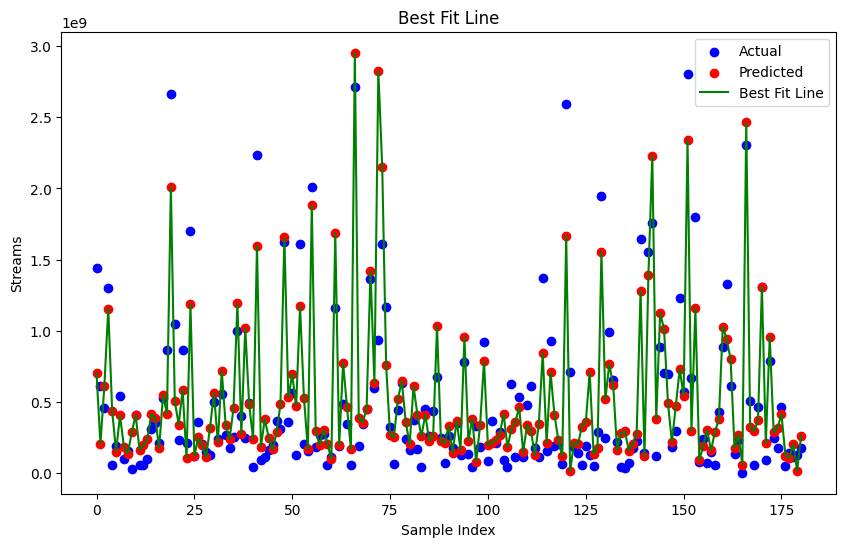

In [ ]:
# Plot the best fit line
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.plot(range(len(y_pred)), y_pred, color='green', label='Best Fit Line')
plt.xlabel('Sample Index')
plt.ylabel('Streams')
plt.legend()
plt.title('Best Fit Line')
plt.show()

In [ ]:
#Create a Neural Net Model

neural_net = MLPRegressor(
                     random_state=42)

param_grid = {
    'hidden_layer_sizes': [(24, 24, 24, 24, 24)],
    'activation': ['relu','logistic'],
    'solver': ['adam','lbfgs'],
    'max_iter': [3000, 4000],
    'alpha': [0.001, 0.01]
}

#Perform grid search with cross-validation to find best params
grid_search = GridSearchCV(estimator=neural_net, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

#
best_neural_net = grid_search.best_estimator_
best_neural_net.fit(X_train_scaled, y_train)

y_pred = best_neural_net.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


R-squared: 0.75


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:09:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:09:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


R-squared: 0.81


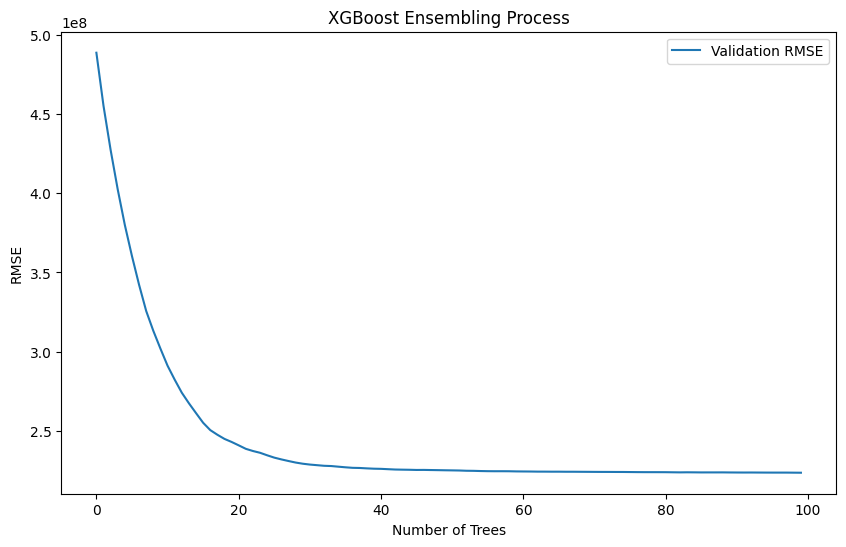

In [ ]:
# creating XGBoost Model (variation of an ensemble algorithm)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DMatrix objects for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dall = xgb.DMatrix(X, label=y)

# Define the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42
}

# Perform cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics=['rmse'], as_pandas=True, seed=42)


# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

# Plot the ensembling process
plt.figure(figsize=(10, 6))
plt.plot(cv_results['test-rmse-mean'], label='Validation RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('XGBoost Ensembling Process')
plt.legend()
plt.show()



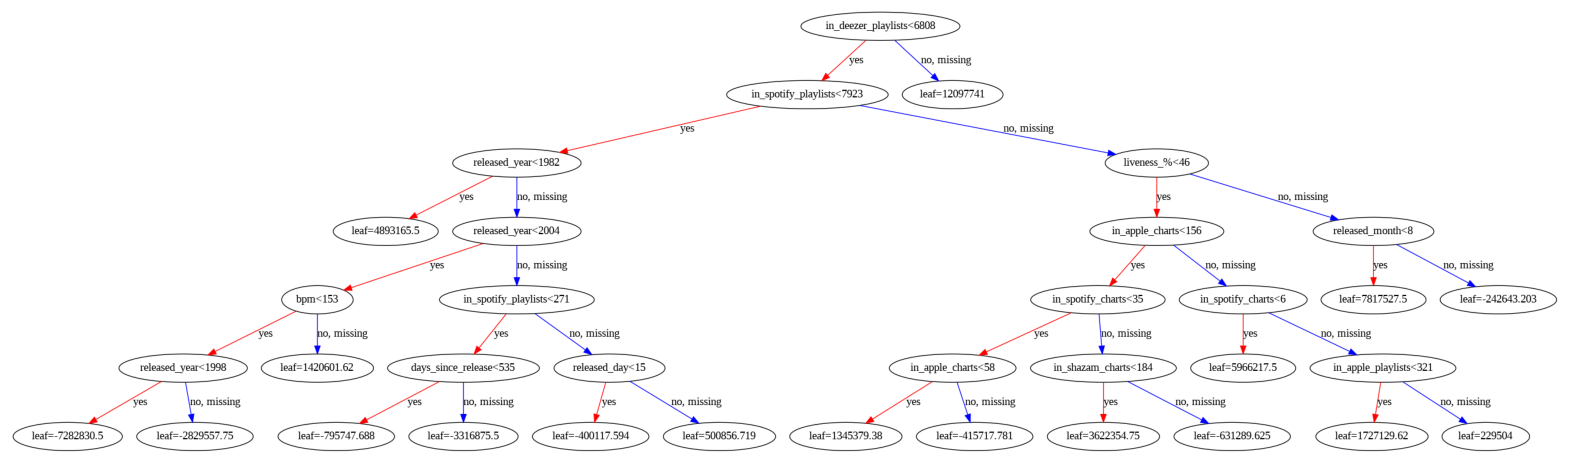

In [ ]:
# if you want to see what a specfic tree would look like

tree_index = 50
fig, ax = plt.subplots(figsize=(20, 10))
plt.rcParams['font.size'] = 14
xgb.plot_tree(xgb_model, num_trees=tree_index, ax=ax)
plt.show()

# Comparing Models

To obtain a more accurate depiction of the performance of each model, we performed a 5-fold cross validation on each one, and compared the resulting evaluation metrics.


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:11

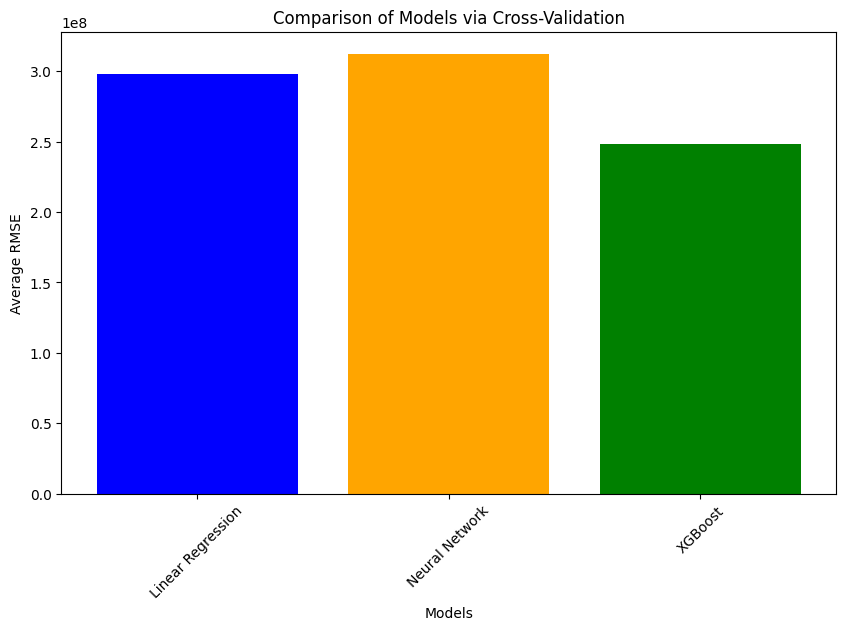

In [ ]:
#Comparing models via Cross-Validation

X_scaled = scaler.transform(X)

#Perform cross validation using all of data for making the folds (5-fold)
cross_val_score_lin_reg = (-cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')).mean()
cross_val_score_nn = (-cross_val_score(best_neural_net, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')).mean()
cross_val_score_xgboost = (xgb.cv(params, dall, num_boost_round=100, nfold=5, metrics=['rmse'], as_pandas=True, seed=42)).mean()[2]

#Plot the average RMSE of each model
average_scores = [cross_val_score_lin_reg, cross_val_score_nn, cross_val_score_xgboost]
model_names = ['Linear Regression', 'Neural Network', 'XGBoost']

plt.figure(figsize=(10, 6))
plt.bar(model_names, average_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Average RMSE')
plt.title('Comparison of Models via Cross-Validation')
plt.xticks(rotation=45)
plt.show()

# Result Analysis


### **Linear Regression Model Analysis**
- **R-squared value:** `0.76`
  - Indicates that **76% of the variance** in the number of streams can be explained by the features used.
- **Root Mean Squared Error:** Approximately 286 million streams
  - Highlights substantial prediction error on an absolute basis, particularly given that song streams can reach the billions.

### **Neural Network Regression Model**
- **Configuration:** 5 hidden layers
- **R-squared value:** `0.75`
  - Slightly worse performance than the linear model, suggesting the added complexity of a neural network does not provide a clear benefit for this dataset.

### **XGBoost Model**
- **Best Performance:** R-squared value of `0.81`
- **Features:**
  - Uses gradient boosted trees.
  - Validation RMSE decreases as more trees are added, stabilizing around 100 trees.
- **Implications:** Indicates potential non-linear relationships and interactions in song features that are effectively captured by this tree-based model.

### **Overall Insights**
- **Highest R-squared:** `0.81`
- **Analysis:**
  - Audio features provide a reasonable prediction of song popularity.
  - There remains significant unexplained variability, influenced by factors like artist fanbase, marketing, and cultural trends.
- **Potential Improvements:**
  - Integration of audio features with artist and release metadata might enhance model effectiveness.


### **Summary**
- This analysis underscores the complex relationship between musical features and song popularity.
- The predictive models, especially the XGBoost, show significant potential for aiding strategic decisions in the music industry.
